In [1]:
from tsai.utils import *
from tsai.basics import *
from matplotlib import dates as mdates
import sklearn
my_setup(sklearn)


os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# AP Geomagnetix Index Data Preprocessing

In [2]:
config_geo = yaml2dict('./config/geoap.yaml', attrdict=True)
config_geo = config_geo.data
config = AttrDict(config_geo)
config

```json
{ 'data_path': '../data/SOLAP.TXT',
  'data_url': 'https://www-app3.gfz-potsdam.de/kp_index/Kp_ap_since_1932.txt',
  'force_download': False}
```

In [3]:
fname = config.solap.data_path if config.data_url is None else download_data(
    config.data_url, fname=config.data_path, force_download=config.force_download)
fname

Path('../data/SOLAP.TXT')

In [4]:
column_names = ["YYYY", "MM", "DD", "hh.h", "hh._m", "days", "days_m", "Kp", "AP", "D"]

# Read the CSV file
df_solap_raw = pd.read_csv(fname, 
                 sep='\s+', 
                 comment='#', 
                 names=column_names
                 )

df_solap_raw['Datetime'] = pd.to_datetime(df_solap_raw[['YYYY', 'MM', 'DD']].astype(str).agg('-'.join, axis=1) + ' ' + df_solap_raw['hh.h'].astype(int).astype(str) + ':00:00')
df_solap_raw.drop(columns=["YYYY", "MM", "DD", "hh.h"], inplace=True)
df_solap_raw = df_solap_raw.drop(['days_m', 'Kp', 'D'], axis=1)
df_solap_raw

,hh._m,days,AP,Datetime
0,1.5,0.000,18,1932-01-01 00:00:00
1,4.5,0.125,12,1932-01-01 03:00:00
2,7.5,0.250,9,1932-01-01 06:00:00
3,10.5,0.375,12,1932-01-01 09:00:00
4,13.5,0.500,18,1932-01-01 12:00:00
...,...,...,...,...
270587,10.5,33823.375,6,2024-08-08 09:00:00
270588,13.5,33823.500,3,2024-08-08 12:00:00
270589,16.5,33823.625,3,2024-08-08 15:00:00
270590,19.5,33823.750,4,2024-08-08 18:00:00


In [5]:
# Check if there are any missing values
df_solap_raw.isna().sum()

hh._m       0
days        0
AP          0
Datetime    0
dtype: int64

In [6]:
# Distinct value of the column AP (classification problem?)
df_solap_raw.AP.unique().__len__()

28

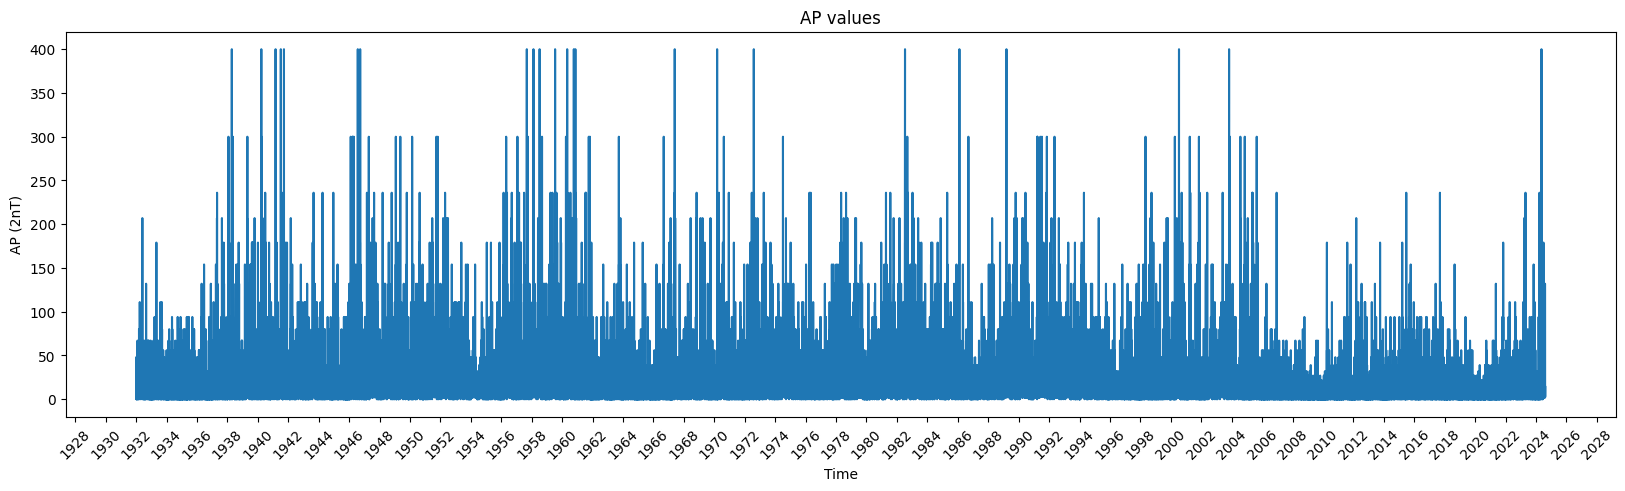

In [7]:
# hide

# Plot the AP values
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_solap_raw.Datetime, df_solap_raw.AP)
ax.set_title('AP values')
ax.set_xlabel('Time')
ax.set_ylabel('AP (2nT)')
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.show()

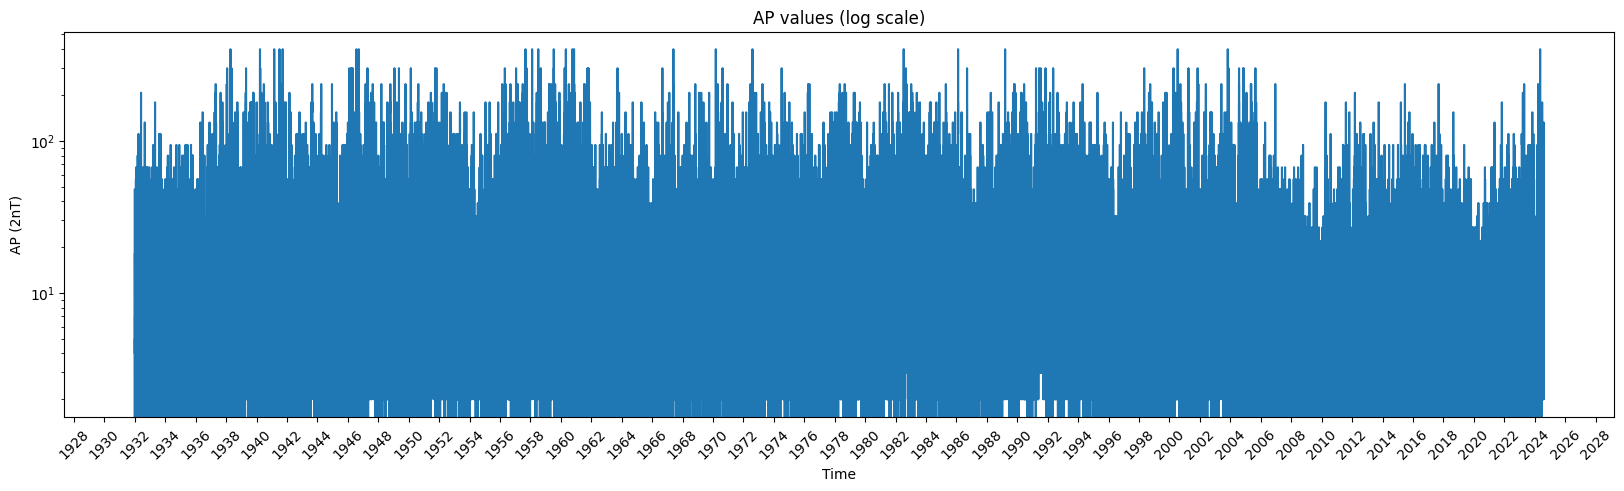

In [8]:
# hide

# Repeat the above plot but with a logarithmic scale
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_solap_raw.Datetime, df_solap_raw.AP)
ax.set_title('AP values (log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('AP (2nT)')
ax.set_yscale('log')
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.show()


In [9]:
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage and set the right dtypes
], verbose=True)

df = preproc_pipe.fit_transform(df_solap_raw)
df

Initial memory usage: 8.26 MB   
Final memory usage  : 4.65 MB    (-43.7%)
[Pipeline] .......... (step 1 of 1) Processing shrinker, total=   0.0s


,hh._m,days,AP,Datetime
0,1.5,0.000,18,1932-01-01 00:00:00
1,4.5,0.125,12,1932-01-01 03:00:00
2,7.5,0.250,9,1932-01-01 06:00:00
3,10.5,0.375,12,1932-01-01 09:00:00
4,13.5,0.500,18,1932-01-01 12:00:00
...,...,...,...,...
270587,10.5,33823.375,6,2024-08-08 09:00:00
270588,13.5,33823.500,3,2024-08-08 12:00:00
270589,16.5,33823.625,3,2024-08-08 15:00:00
270590,19.5,33823.750,4,2024-08-08 18:00:00


In [10]:
save_object(df, "./preprocessed_data/dataframes/geoap.pkl")
save_object(preproc_pipe, "./preprocessed_data/pipelines/preproc_geoap.pkl")

preprocessed_data/dataframes directory already exists.
DataFrame saved as preprocessed_data/dataframes/geoap.pkl
preprocessed_data/pipelines directory already exists.
Pipeline saved as preprocessed_data/pipelines/preproc_geoap.pkl
